## Sliding 3D

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pylops

from pympler import asizeof
from pylops.signalprocessing.sliding3d import sliding3d_design
from pylops.utils.describe import describe

from pylops.signalprocessing import Sliding3D
from sliding3dold import Sliding3D as Sliding3DOLD
from visual import explode_volume

USE_CUPY = False

In [2]:
if USE_CUPY:
    import cupy as np
    from cupyx.profiler import benchmark
    np_asarray = np.asarray
    np_asnumpy = np.asnumpy
    np_float = np.float32
    np_floatc = np.complex64
    mempool = np.get_default_memory_pool()
    fftengine = 'numpy'
    fftkwargs = dict()
else:
    np_asarray = np.asarray
    np_asnumpy = np.asarray
    np_float = np.float64
    np_floatc = np.complex128
    fftengine = 'scipy'
    fftkwargs = dict(workers=16)

In [3]:
def bench_Op(Op, x):
    return Op @ x

def bench_OpH(Op, x):
    return Op.H @ x

In [4]:
savetaper = False
tapertype = 'cosine' # cannot match old for other than None, as edges were not implemented...

In [5]:
nwin = (26, 24)
nover = (11, 9)
nop = 32
#dimsd = (200, 200, 32) # small
dimsd = (400, 400, 32) # large

y = np.random.normal(0, 1, dimsd[0]*dimsd[1]*dimsd[2]).reshape(dimsd).astype(np_float)

nwins, dims, _, _ = sliding3d_design(dimsd, nwin, nover, (nop, nop, (nop + 2) // 2))

# no operator broadcast
Op = pylops.signalprocessing.FFTND((nwin[0], nwin[1], dimsd[2]), nffts=(nop, nop, nop),
                                   axes=(-3, -2, -1), sampling=(1, 1, 1), 
                                   real=True, engine=fftengine,
                                   dtype=np_floatc, **fftkwargs)
Slid = Sliding3DOLD(
    Op.H, dims, dimsd, nwin, nover, (nop, nop, (nop + 2) // 2), tapertype=tapertype)
Slid1a = Sliding3D(Op.H, dims, dimsd, nwin, nover, (nop, (nop + 2) // 2), 
                   tapertype=tapertype, savetaper=savetaper)

# with operator broadcast
Op = pylops.signalprocessing.FFTND((nwins[0], nwins[1], nwin[0], nwin[1], dimsd[2]), nffts=(nop, nop, nop), 
                                   axes=(-3, -2, -1), sampling=(1, 1, 1), real=True, 
                                   engine=fftengine,
                                   dtype=np_floatc, **fftkwargs)
Slid1b = Sliding3D(Op.H, dims, dimsd, nwin, nover, (nop, nop, (nop + 2) // 2), tapertype=tapertype)

x = Slid.H * y.ravel()

 270 285 300 315 330 345 360], end:[ 26  41  56  71  86 101 116 131 146 161 176 191 206 221 236 251 266 281
 296 311 326 341 356 371 386] / start:[  0  15  30  45  60  75  90 105 120 135 150 165 180 195 210 225 240 255
 270 285 300 315 330 345 360 375], end:[ 24  39  54  69  84  99 114 129 144 159 174 189 204 219 234 249 264 279
 294 309 324 339 354 369 384 399]
 576 608 640 672 704 736 768], end:[ 32  64  96 128 160 192 224 256 288 320 352 384 416 448 480 512 544 576
 608 640 672 704 736 768 800] / start:[  0  32  64  96 128 160 192 224 256 288 320 352 384 416 448 480 512 544
 576 608 640 672 704 736 768 800], end:[ 32  64  96 128 160 192 224 256 288 320 352 384 416 448 480 512 544 576
 608 640 672 704 736 768 800 832]


In [6]:
print(np.allclose(Slid @ x, Slid1a @ x), np.allclose(Slid.H @ y, Slid1a.H @ y))
print(np.allclose(Slid @ x, Slid1b @ x), np.allclose(Slid.H @ y, Slid1b.H @ y))

False False
False False


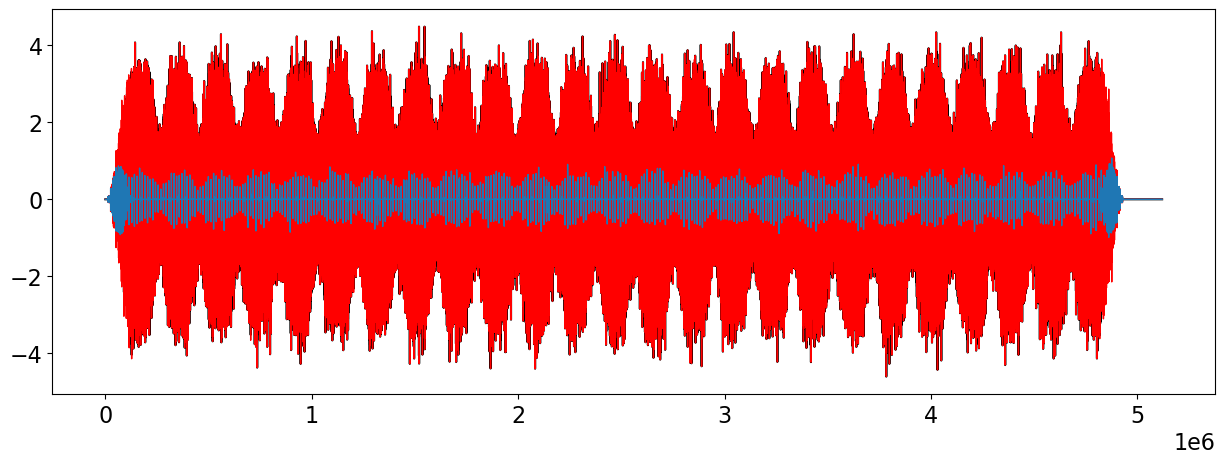

In [9]:
plt.figure(figsize=(15, 5))
plt.plot((Slid @ x).ravel(), 'k')
plt.plot((Slid1a @ x).ravel(), 'r', lw=1)
plt.plot((Slid @ x).ravel()-(Slid1a @ x).ravel(), lw=1);

In [8]:
if not USE_CUPY:
    %timeit -n 5 -r 10 Slid * x # OLD
    %timeit -n 5 -r 10 Slid1a * x # NEW
    %timeit -n 5 -r 10 Slid1b * x # NEW with Op broadcasted
else:
    print(benchmark(bench_Op, (Slid, x,), n_repeat=20))
    print(benchmark(bench_Op, (Slid1a, x,), n_repeat=20))
    print(benchmark(bench_Op, (Slid1b, x,), n_repeat=20))

KeyboardInterrupt: 

In [ ]:
if not USE_CUPY:
    %timeit -n 5 -r 10 Slid.H * y # OLD
    %timeit -n 5 -r 10 Slid1a.H * y # NEW
    %timeit -n 5 -r 10 Slid1b.H * y # NEW with Op broadcasted
else:
    print(benchmark(bench_OpH, (Slid, y,), n_repeat=20))
    print(benchmark(bench_OpH, (Slid1a, y,), n_repeat=20))
    print(benchmark(bench_OpH, (Slid1b, y,), n_repeat=20))

In [ ]:
print(asizeof.asizeof(Slid) * 1e-6, asizeof.asizeof(Slid1a) * 1e-6, asizeof.asizeof(Slid1b) * 1e-6) 

In [10]:
# Checking sliding with taper
nwin = (26, 24)
nover = (11, 9)
nop = 32
dimsd = (191, 189, 32) # small
tapertype = 'cosine'

nwins, dims, _, _ = sliding3d_design(dimsd, nwin, nover, (nwin[0], nwin[1], dimsd[2]))

In [11]:
# no operator broadcast
Op = pylops.Identity((nwin[0], nwin[1], dimsd[2]))
Slid1a = Sliding3D(Op.H, dims, dimsd, nwin, nover, (nwin[1], dimsd[2]), 
                   tapertype=tapertype)

x = np.ones(Slid1a.dims) + 0.
y = Slid1a @ x

np.unique(y)

array([1., 1.])

In [12]:
# operator broadcast
Op = pylops.Identity((nwins[0], nwins[1], nwin[0], nwin[1], dimsd[2]))
Slid1b = Sliding3D(Op.H, dims, dimsd, nwin, nover, (nwin[1], dimsd[2]), 
                   tapertype=tapertype)

x = np.ones(Slid1a.dims) + 0.
y = Slid1a @ x

np.unique(y)

array([1., 1.])

In [13]:
# Check that the results with and without the savetaper are the same
nwin = (26, 24)
nover = (11, 9)
nop = 32
#dimsd = (200, 200, 32) # small
dimsd = (400, 400, 32) # large

nwins, dims, _, _ = sliding3d_design(dimsd, nwin, nover, (nop, nop, (nop + 2) // 2))

# no operator broadcast
Op = pylops.signalprocessing.FFTND((nwin[0], nwin[1], dimsd[2]), nffts=(nop, nop, nop),
                                   axes=(-3, -2, -1), sampling=(1, 1, 1), 
                                   real=True, engine=fftengine, workers=16, 
                                   dtype=np_floatc)
Slid1a = Sliding3D(Op.H, dims, dimsd, nwin, nover, (nop, (nop + 2) // 2), 
                   tapertype=tapertype, savetaper=True)
Slid1ano = Sliding3D(Op.H, dims, dimsd, nwin, nover, (nop, (nop + 2) // 2), 
                   tapertype=tapertype, savetaper=False)

# with operator broadcast
Op = pylops.signalprocessing.FFTND((nwins[0], nwins[1], nwin[0], nwin[1], dimsd[2]), nffts=(nop, nop, nop), 
                                   axes=(-3, -2, -1), sampling=(1, 1, 1), real=True, 
                                   engine=fftengine, workers=16, 
                                   dtype=np_floatc)
Slid1b = Sliding3D(Op.H, dims, dimsd, nwin, nover, (nop, nop, (nop + 2) // 2), 
                   tapertype=tapertype, savetaper=True)
Slid1bno = Sliding3D(Op.H, dims, dimsd, nwin, nover, (nop, nop, (nop + 2) // 2), 
                   tapertype=tapertype, savetaper=False)

#y = np.arange(dimsd[0]*dimsd[1]*dimsd[2]).reshape(dimsd).astype(np_float)
y = np.random.normal(0., 1., dimsd[0]*dimsd[1]*dimsd[2]).reshape(dimsd).astype(np_float)

x = Slid1a.H * y.ravel()
x1 = Slid1ano.H * y.ravel()

 270 285 300 315 330 345 360], end:[ 26  41  56  71  86 101 116 131 146 161 176 191 206 221 236 251 266 281
 296 311 326 341 356 371 386] / start:[  0  15  30  45  60  75  90 105 120 135 150 165 180 195 210 225 240 255
 270 285 300 315 330 345 360 375], end:[ 24  39  54  69  84  99 114 129 144 159 174 189 204 219 234 249 264 279
 294 309 324 339 354 369 384 399]
 576 608 640 672 704 736 768], end:[ 32  64  96 128 160 192 224 256 288 320 352 384 416 448 480 512 544 576
 608 640 672 704 736 768 800] / start:[  0  32  64  96 128 160 192 224 256 288 320 352 384 416 448 480 512 544
 576 608 640 672 704 736 768 800], end:[ 32  64  96 128 160 192 224 256 288 320 352 384 416 448 480 512 544 576
 608 640 672 704 736 768 800 832]


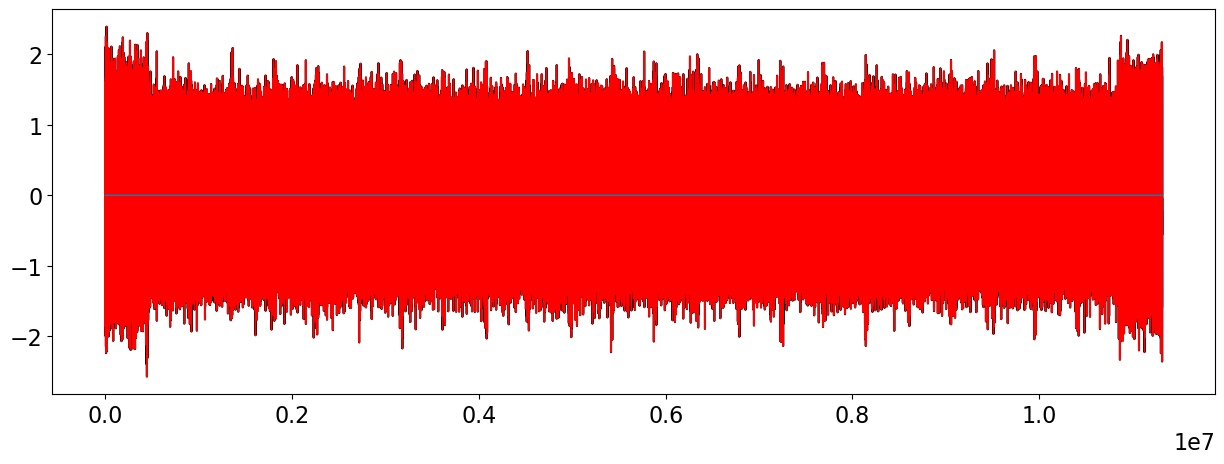

In [14]:
plt.figure(figsize=(15, 5))
plt.plot(x.ravel(), 'k')
plt.plot(x1.ravel(), 'r', lw=1)
plt.plot(x.ravel()-x1.ravel(), lw=1);

True

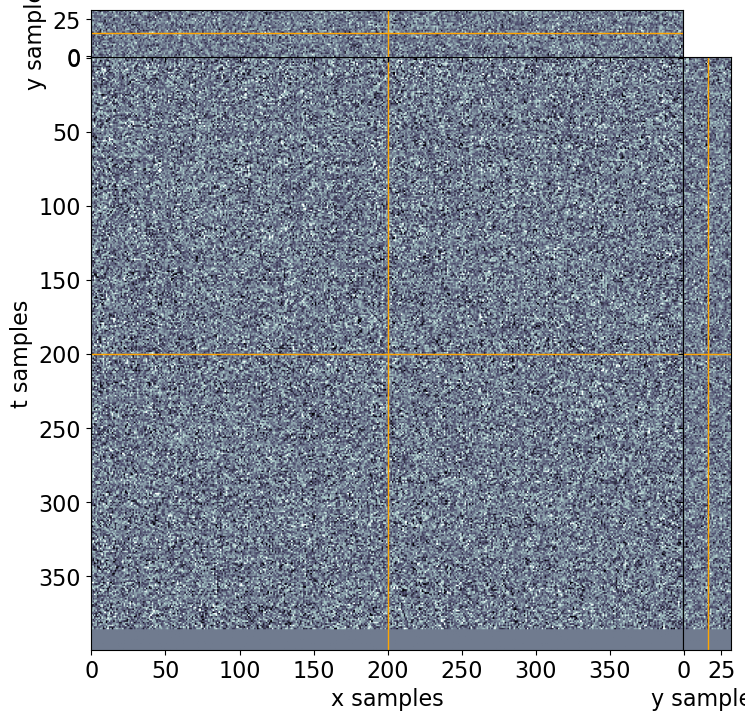

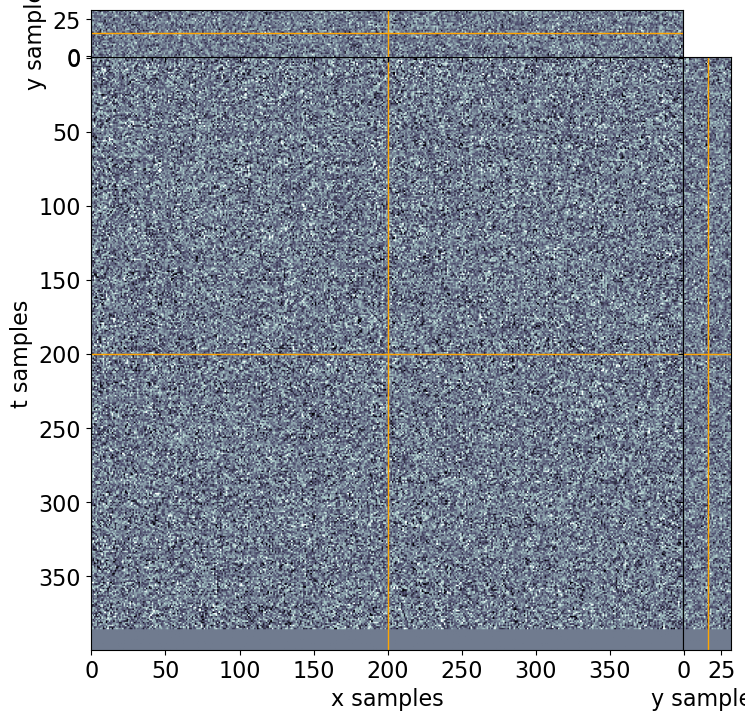

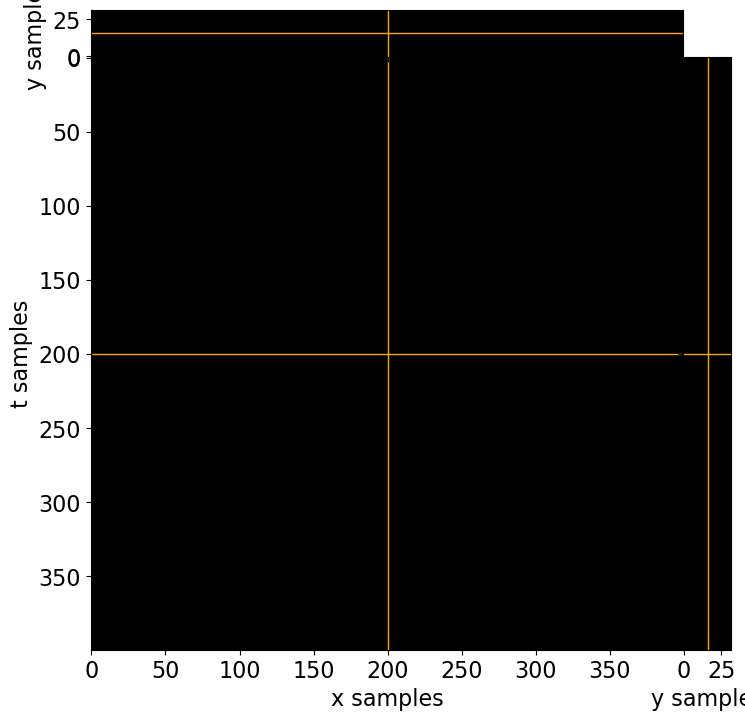

In [15]:
x = np.random.normal(0, 1, Slid1a.dims).astype(np_float)

y = Slid1a @ x
y1 = Slid1ano * x

explode_volume(y.real)
explode_volume(y1.real)
explode_volume(y.real - y1.real)

np.allclose(y, y1)

In [16]:
print(np.allclose(Slid1a @ x, Slid1ano @ x), np.allclose(Slid1a.H @ y, Slid1ano.H @ y))
print(np.allclose(Slid1b @ x, Slid1bno @ x), np.allclose(Slid1b.H @ y, Slid1bno.H @ y))

True True
True True


In [17]:
print(asizeof.asizeof(Slid1a) * 1e-6, asizeof.asizeof(Slid1ano) * 1e-6, 
      asizeof.asizeof(Slid1b) * 1e-6, asizeof.asizeof(Slid1bno) * 1e-6) 

207.67870399999998 2.8868959999999997 207.678448 2.88664
